## This notebook is used for testing OFC configurations

Step-by-step description of what we do can be found in 
Jira test case: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T???? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

'lsst-nts-kub06'

In [3]:
from lsst.ts import salobj
import asyncio
import os

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import yaml

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

Update leap second table
current_tai uses the system TAI clock


<Figure size 432x288 with 0 Axes>

In [4]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/ts_ddsconfig/config/ospl-shmem.xml
ncsa
0


In [5]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

Read historical data in 0.00 sec


In [6]:
aos = salobj.Remote(script.domain, "MTAOS")

Read historical data in 0.16 sec


In [7]:
await aos.start_task

In [58]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
aos.evt_logMessage.callback = printLogMessage
#await aos.cmd_setLogLevel.set_start(level=10, timeout=5)
await aos.cmd_setLogLevel.set_start(level=30, timeout=5)

In [9]:
await aos.evt_heartbeat.next(flush=True, timeout=5)

In [10]:
#summit = 1 #use this for summit testing
summit = 0 #use this for NCSA

In [11]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

### play with re-configuring OFC

https://github.com/lsst-ts/ts_ofc/blob/develop/python/lsst/ts/ofc/ofc_data/base_ofc_data.py#L54

https://github.com/lsst-ts/ts_ofc/blob/develop/python/lsst/ts/ofc/ofc_data/ofc_data.py#L64

In [12]:
zernikes = np.zeros(19)
zerIdx = np.arange(4, 23)
zernikes[7-4] = 1 #add 1um of z7
print(zerIdx)
print(zernikes)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
await aos.cmd_addAberration.set_start(wf = zernikes)
dof = await aos.evt_degreeOfFreedom.aget(timeout = 5.)
await aos.cmd_resetCorrection.set_start()

10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


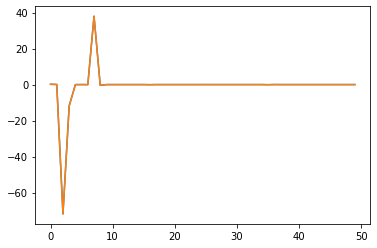

In [29]:
plt.plot(dof.aggregatedDoF)
plt.plot(dof.visitDoF)

In [ ]:
config = {}

#### alpha : `np.array` of `float`
        Alpha coefficient for the normalized point-source sensitivity (PSSN).

This won't be used often. But test whether we can change it and whether the change makes sense.

In [43]:
alpha = np.array(
        [
            6.6906168e-03,
            9.4460611e-04,
            9.4460611e-04,
            6.1240430e-03,
            6.1240430e-03,
            1.7516747e-03,
            1.7516747e-03,
            4.9218300e-02,
            9.4518035e-03,
            9.4518035e-03,
            3.0979027e-03,
            3.0979027e-03,
            4.5078901e-02,
            4.5078901e-02,
            1.2438449e-02,
            1.2438449e-02,
            4.5678764e-03,
            4.5678764e-03,
            3.6438430e-01,
        ]
    )
config["alpha"] = (alpha/2).tolist()
config_yaml = yaml.safe_dump(config)

In [44]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)
dof_alpha = await aos.evt_degreeOfFreedom.aget(timeout = 5.)
await aos.cmd_resetCorrection.set_start()

10: Customizing OFC parameters.
10: Overriding ofc_data parameter alpha.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter alpha.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


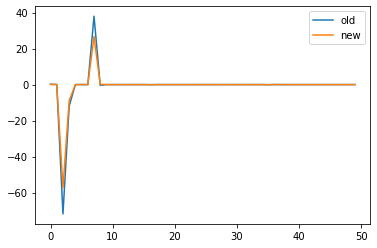

In [45]:
plt.plot(dof.aggregatedDoF, label='old')
plt.plot(dof_alpha.aggregatedDoF, label='new')
plt.legend();

Does the above make sense?

$$ 
J = x^T Q x + \rho (u-u_r)^T H (u-u_r)
$$

$\alpha$'s are the diagonal elements of Q.

Yes. If $\alpha$'s and $\rho$ decrease at the same time, the results wouldn't change. (we will check that next)

Decreasing $\alpha$'s alone is equivalent to increasing $\rho$ by itself without changing anything else. Of course, increasing the penalty on the motions will publish the motions and results in smaller motions.

#### Now we decrease $\alpha$'s and $\rho$ at the same time, the corrections should be the same as no change

#### motion_penalty : `float`
        Penalty on control motion as a whole.
        
        Note: the $\rho$ above is this `motion_penalty` SQUARED.

Penalty on control motion as a whole.
The common language (reference) is M2 hexapod piston in um.
How many microns of M2 piston does pssn degradation of 1 correspond to?
It turns out 1000um is a good number. (so that is 1um for 0.001 of PSSN.)
But this penalty below is applied on motion, instead of IQ, so we need to invert 1/1000 = 0.001
Use 0, if you accept whatever motion needed to produce best image quality.
Use 1e100, if you absolutely hate anything that moves.

In [46]:
motion_penalty: float = 0.001

In [54]:
config["motion_penalty"] = motion_penalty/np.sqrt(2.0)  # add config as needed
config_yaml = yaml.safe_dump(config)

In [55]:
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)
dof_alpha_rho = await aos.evt_degreeOfFreedom.aget(timeout = 5.)
await aos.cmd_resetCorrection.set_start()

10: Customizing OFC parameters.
10: Overriding ofc_data parameter alpha.
10: Overriding ofc_data parameter motion_penalty.
10: Currently configured with comcam instrument.
10: Assuming white light filter to compute aberration.
10: Error setting pssn gain. Using default: 0.7.
10: Restoring ofc_data values.
10: Overriding ofc_data parameter alpha.
10: Overriding ofc_data parameter motion_penalty.
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().
20: Execute do_resetCorrection().
20: Execute pubEvent_degreeOfFreedom().
20: Execute pubEvent_m2HexapodCorrection().
20: Execute pubEvent_cameraHexapodCorrection().
20: Execute pubEvent_m1m3Correction().
20: Execute pubEvent_m2Correction().


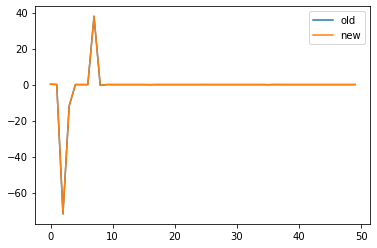

In [56]:
plt.plot(dof.aggregatedDoF, label='old')
plt.plot(dof_alpha_rho.aggregatedDoF, label='new')
plt.legend();

In [ ]:
async def ofcUpdateConfig(aos, zernikes, config, dof0):
    config_yaml = yaml.safe_dump(config)

    await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml)
    dof = await aos.evt_degreeOfFreedom.aget(timeout = 5.)
    await aos.cmd_resetCorrection.set_start()

    plt.plot(dof0.aggregatedDoF, label='old')
    plt.plot(dof.aggregatedDoF, label='new')
    plt.legend();
    
return dof

In [ ]:
# try rho = 0


In [ ]:
# try rho = 1e100


#### control_strategy : `string`
        Name of the control strategy.
        
# We can set rho = 0 to achieve control_strategy = null. yes.
# If we keep control_strategy, we need to make a list with available options. Or, we can get rid of it.
# This is listed in both OFCdata and baseOFCData. Is that intended?

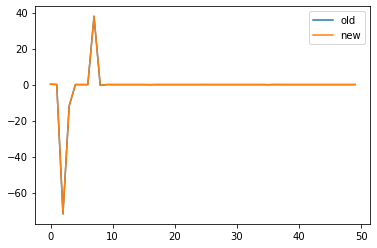

In [60]:
config['control_strategy'] = 'null'
dof_strategy = ofcUpdateConfig(aos, zernikes, config, dof0)

In [ ]:
config['control_strategy'] = 'optiPSSN'
config['motion_penalty'] = 0
dof_penalty_0 = ofcUpdateConfig(aos, zernikes, config, dof0)

In [2]:
print(config)

NameError: name 'config_yaml' is not defined

###     xref : `string` Default is x00
        Define how the control strategy will handle the reference point.
###     xref_list : `list` of `string` Default is {"x00", "x0", "0"}
        Available reference point strategies.

# What I write below need to be tested in this notebook

x0: It references the current state, i.e., current positions of the hexapods and current forces on the mirrors. With this, `dof_state0_filename` will NOT make any difference. 

x00: this references where x0 started at iteration 0. The starting position is defined by `dof_state0_filename`. 
Moving back to `dof_state0` is most preferable, i.e., u=-aggregatedDOF is the most preferable.
So `aggregatedDOF` is all that the OFC needs. `dof_state0_filename` will NOT make any difference. 

0: It references the zero position of the hexapods, zero aos forces on the mirrors. This will be useful if drifting becomes a main concern.
Because moving back to 0, i.e., u=-x0, is most preferable, OFC needs to know x0, i.e., it needs to know where we are. The OFC knows where we are from (dof_state0 + aggreatedDOF). So, `dof_state0_filename` should make a difference.
Right now, these are put as all zeros, which makes this option same as "x00" above. 
But the planned usage is that I will set the mirror bending modes as all zeros, and hexapod state0 at their LUT positions (get them from `evt_compensationOffset`).

Note that even though the mirrors absorb bending modes into their LUTs, they are applied as individual forces; the mirrors know nothing about bending modes. And, those bending modes absorbed into the mirror LUTs are supposed to reduce stress on the glass.

In principle, we can use this feature to reference any position. If you want to reference state X, put -X in `dof_state0_filename`.
But in reality, what makes most sense is to use the hexapod compensationOffset as described above.

In [ ]:
## add same aberration twice, the corrections do NOT double

await aos.cmd_resetCorrection.set_start()

In [ ]:
## Double the aberration, do the corrections double? yes
zernikes[7-4] = 2 # z7 = 2um

await aos.cmd_resetCorrection.set_start()

In [97]:
#change xref, dof will be different
config["xref"] = "x0"  # add config as needed
dof_xref_x0 = ofcUpdateConfig(aos, zernikes, config, dof0)

In [ ]:
## add same aberration twice, the corrections now double

await aos.cmd_resetCorrection.set_start()

### dof_state0_filename : `string`
        Name of the file with the initial degrees of freedom.

# Next, need to talk to Tiago, to pass `dof_state0_filename` as a dictionary, not a file. 

In [ ]:
dof_state0_filename: str = "state0inDof.yaml"

### eff_wavelength : `dict` of `string`
        Effective wavelength in um for each filter.
The only reason the eff_wavelength matters is that (1-PSSN) is proportional to Zernike square in radian.

This enters as $Q=(2\pi/\lambda)^2O$. So if we double $\lambda$, it is like increasing penalty on motions. 
If we double $\lambda$ and multiple $\alpha$ by 4, output will stay the same.

In [4]:
config["eff_wavelength"] = 1.0
dof_effwave_1 = ofcUpdateConfig(aos, zernikes, config, dof0)

2.3548200450309493

In [ ]:
config["alpha"] = (alpha*4.).tolist()
dof_effwave_alpha = ofcUpdateConfig(aos, zernikes, config, dof0)

### intrinsic_zk_filename_root : `string`
        Filename root string for the intrinsic zernike coefficients.
        
These matter if the inputs to OFC are measured Zernikes. They should not matter for `cmd_addAberration`.
        
# Where do we make copies of these files? login onto the kb pods???

#### iqw_filename : `str`
        Image quality weight filename.
These are the GQ weights. They will make differences to the OFC output. For example, if we set all fields other than field center to zero weight, the resulting motions will only be optimizing the field center.

### m1m3_actuator_penalty : `float`
        M1M3 actuator penalty factor.

The common language (reference) is M2 hexapod piston in um.

How many microns of M2 piston does 1N rms force correspond to?

The bigger the number, the bigger the penalty

 13.2584 below = 5900/445. 
 
445 means 445N, rms reaching 445N is as bad as M2 piston reaching 5900um

M1M3_actuator_penalty   13.2584

If we double this number, M1M3 forces will decrease.

In [ ]:
config["M1M3_actuator_penalty"] =   13.2584

### m2_actuator_penalty : `float`
        M2 actuator penalty factor.
The common language (reference) is M2 hexapod piston in um.

How many microns of M2 piston does 1N rms force correspond to?

The bigger the number, the bigger the penalty

M2 F budget for AOS = 44N. 5900/44 = 134

M2_actuator_penalty   134

In [ ]:
config["M2_actuator_penalty"] = 134

### rb_stroke : `np.array` of `float`
        Allowed moving range of rigid body of M2 hexapod and Camera hexapod in
        the unit of um. e.g. rbStroke[0] means the M2 piston is allowed to move
        +5900 um to -5900 um.
These can be used to adjust the relative weighting between the 10 rigid body DOFs of the two hexapods.

H = block_diag(mHr, rhoM13**2*mHM13, rhoM2**2*mHM2)

In [ ]:
rb_stroke: np.ndarray = np.array(
        [5900, 6700, 6700, 432, 432, 8700, 7600, 7600, 864, 864]
    )

### sen_m_filename_root : `string`
        Filename root string for the sensitivity matrix M.
        
If we double all elements, only half of the motion will be needed.

# Should we simply have `sensitivity_matrix_file`?

In [ ]:
sen_m_filename_root: str = "senM"

### sensor_mapping_filename : `string`
        Name of the file with the mapping between the sensor name and field
        index.
comcam has 9 rows.

lsstfam has 189 rows.

# lsst has 201 rows: 189+12 sensors are mapped to 35 field points? how? Te-Wei?

These will never need to be reconfigured.

# How do I change instrument? using the below?

###     name : `string`
        Name of the instrument configuration. This is used to define where
        `intrinsic_zk` and `y2` will be read from.

# not just intrinsic_zk and y2 right? there are more files in those folders.

In [ ]:
config["name"] = "lsst"

### y2_filename : `string`
        Name of the file where `y2_correction` is read from.
comcam: 9x19, for z4-z22

lsst: 35x19, for z4-z22

lsstfam: 189x19, for z4-z22

This y2 characterizes the difference between field center and corner wavefronts.
This difference is mostly produced by the uncontrolled DOFs such as those internal to the camera. The difference in the design aberration contributes to the difference between center and corner as well, but on a much less significant level.
The common component (between corner and center) produced by the uncontrolled DOF is already captured in the estimated system state (x^hat). This y2 here captures the part that differs between corner and the field center.

y2 for comcam and lsstfam are not really needed, because there is no concept of field center vs corner. They should always stay at all zeros. For `lsst`, we will need to calibrate and put in non-zero values.

What we need to do in reality is that we will produce maps of Zn across the focal plane, including corner and field center. We then subtract the averages of the corners for each Zn, so that on the new maps the corner wavefront for each Zernike averages to zero. If the center turns out to be negative that means we need to reduce the wavefront estimates from CWFS before they are used for state estimation.

As a test, we can make the following change to `lsst` y2: leave fields 32-35 at 0, make fields 1-31 to be -1um of z7.
But, this is not expected to have any effect on `cmd_addAberration`.
This command attempts to add 1um of Z7 to each of the 4 corners. y2 will only have an impact on OFC when the input wavefront errors are from `evt_wavefrontError`.

###     zn3_idx : `np.array` of `bool`
        Index of annular Zernike polynomials (z3-z22) (`True`: in use, `False`:
        not in use).
Test: with the 1um z7 `cmd_addAberration`, if we use `zn3_idx` to set z7 to False, we should get some crazy corrections. It shouldn't be zero, because it may attempt using other Zernikes such as z17 to add z7.

# The below is how this is initialized in the code. Do we need to make it an array of ones and zeros???

In [ ]:
zn3_idx: np.ndarray = np.arange(19)

In [1]:
import numpy as np

In [6]:
np.ones(19)*True

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

### zn3_idx_in_intrinsic_zn_file : `int`
        Specify where the zernike data starts when reading the intrinsic
        zernike coefficients.
# Does this need to be reconfigured?

### znmax : `int`
        Max number of zernikes used (to be filtered with `zn3_idx`).
Try to use znmax = 23, does that work? I recall z23 was never implemented. So it should give an error

Try to use znmax = 6. This should produce some crazy results because it is not possible to add z7 using znmax=6.

### bend_mode : `dict`
        Dictionary to hold bending mode data. The data is read alongside the
        other files when the name is set.
# Should we get rid of the rotMatxxx.yaml? Are they being used? or just a note to ourselves. The explanations about the coordinate systems are confusing, which makes users more confused. Why do we have "act: 1.0"? shouldn't we have 3 numbers for x,y, and z, if they are for coordinate transformation?

If we make all the bending modes half of their size. The corrections in DOF will be about double? No, these bending modes are just for sending out force commands, and determining control authority. How will the output DOFs change?: we will see mirror DOFs increase, because reducing these is simply reducing the penalties on the bending modes. Do not forget, updating these bending modes requires updating the senM at the same time, or it doesn't make sense.

Reduce `rb_stroke` by half at the same time would keep the output DOFs unchanged.

In [ ]:
self.bend_mode = {
    "M1M3": {
        "force": {"filename": "M1M3_1um_156_force.yaml"},
        "rot": {"filename": "rotMatM1M3.yaml"},
    },
    "M2": {
        "force": {"filename": "M2_1um_72_force.yaml"},
        "rot": {"filename": "rotMatM2.yaml"},
    },
}

### config_dir : `pathlib.Path`
        Path to the directory storing configuration files.

# Make a copy of `policy`, call it `policy_whatever`, and point it this?

# While trying to redefine this, do we need to supply the full path as seen on the kb pod???

Test: 

* give a non-existent path, observe the error message
* the folder only has M1M3, and empty, observe the error message
* the folder only has M1M3, with one file, observe the error message
* the folder only has M1M3, with two files, observe the error message
* do the same for M2, step by step.
* do the same for comcam, step by step.
* double senM, save it to the new folder. OFC outputs should all be reduced by half.

###     dof_idx : `dict` of `string`
        Index of Degree of Freedom (DOF).
        
# what is dof_idx vs comp_dof_idx??

In [75]:
# Disable all corrections except camera hexapod
new_comp_dof_idx = dict(
    m2HexPos=np.zeros(5, dtype=bool).tolist(),
    camHexPos=np.ones(5, dtype=bool).tolist(),
    M1M3Bend=np.zeros(20, dtype=bool).tolist(),
    M2Bend=np.zeros(20, dtype=bool).tolist(),
)
config = {"comp_dof_idx":new_comp_dof_idx}
config_yaml = yaml.safe_dump(config)
await aos.cmd_addAberration.set_start(wf = zernikes, config=config_yaml) 

40: Error setting value in ofc_data. Restoring original values.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=219186663, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Size of input vector (4) different than expected (5).')

40: Callback <bound method MTAOS.do_addAberration of <lsst.ts.MTAOS.mtaos.MTAOS object at 0x7f57eaeeee50>> failed with data=private_revCode: 8adfd49b, private_sndStamp: 1621014608.1501071, private_rcvStamp: 1621014608.1506572, private_seqNum: 219186663, private_identity: Script:7, private_origin: 7807, private_host: 0, wf: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], config: comp_dof_idx:
  M1M3Bend:
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  M2Bend:
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  - false
  camHexPos:
  - true
  - true
  - true
  - true
  - true
  m2HexPos:
  - false
  - false
  - false
  - false
  - false



    field_idx : `dict` of `string`
        Mapping between sensor name and field index.
        --- how is this different from `sensor_mapping_filename`?
    idx_dof : `dict` of `string`
        Index of Degree of Freedom (DOF)
        --- how is this different from `dof_idx`?
    intrinsic_zk : `dict` of `string`
        Intrinsic zernike coefficients per band per detector for a specific
        instrument configuration.
        --- vs `intrinsic_zk_filename_root`
    log : `logging.Logger`
        Logger class used for logging operations.
        --- do I need to configure this?
    sensitivity_matrix : `np.ndarray` of `float`
        Sensitivity matrix M.
        --- vs. sen_m_filename_root?
    start_task : `asyncio.Future`
        Asyncio future that tracks whether the class is setup and ready or not.
        --- do I need to configure this?
    y2_correction : `np.ndarray` of `float`
        Y2 correction.
        --- vs `y2_filename`?

# Go through all the .esti and .ctrl files in IM, and see if anything is missing

# should we let the user pass a H matrix? we may need to configure individual off-diagonal elements.

#### Useful configs:

1. motion_penalty = 0.001
2. control_strategy = optiPSSN

In [76]:
config_yaml

'comp_dof_idx:\n  M1M3Bend:\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  M2Bend:\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  - false\n  camHexPos:\n  - true\n  - true\n  - true\n  - true\n  - true\n  m2HexPos:\n  - false\n  - false\n  - false\n  - false\n  - false\n'

### Close up

In [129]:
await salobj.set_summary_state(aos, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]